# Лабораторная работа №4. Математическое прогнозирование

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_percentage_error
import itertools
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [251]:
data = pd.read_csv('./GoldUP.csv')

In [253]:
data

,Date,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
0,01-10-2000,4538,1455.51,8.00,46.318297,3711.02,37.23,116.65
1,01-11-2000,4483,1512.47,8.00,46.783613,3997.99,37.31,115.24
2,01-12-2000,4541,1178.11,8.00,46.745856,3972.12,36.98,109.56
3,01-01-2001,4466,1208.18,8.00,46.536033,4326.72,36.90,110.52
4,01-02-2001,4370,1267.18,7.50,46.514595,4247.04,36.73,112.01
...,...,...,...,...,...,...,...,...
234,01-04-2020,45504,1603.02,4.65,76.222334,33717.62,125.85,99.57
235,01-05-2020,46343,2298.55,4.25,75.666063,32424.10,126.24,98.34
236,01-06-2020,47315,2987.46,4.25,75.763427,34915.80,127.00,97.39
237,01-07-2020,49878,3156.01,4.25,74.908993,37606.89,128.53,93.35


In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Date'] = data['Date'].dt.to_period('M').dt.to_timestamp()

mask = (data['Date'] >= '2001-01-01') & (data['Date'] <= '2006-12-01')
data = data.loc[mask]

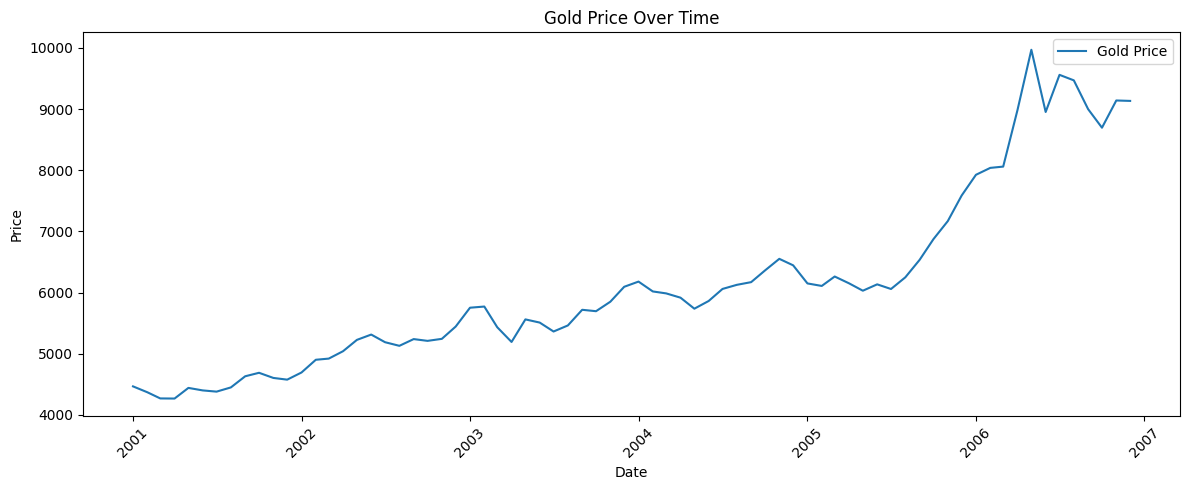

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data['Date'], data['Gold_Price'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def holt_winters_additive(df, alpha1, alpha2, alpha3, n_seasons, n_pred):

    df_train = np.array(df[:-(n_seasons * n_pred)])
    df_test = np.array(df[-(n_seasons * n_pred):])

    n_periods = int(len(df_train) / n_seasons)

    # вычисление тренда и начальных a(0) и b(0)
    x = np.arange(1, len(df_train)+1)
    y = np.array(df_train)
    a, b = np.polyfit(x, y, 1) 

    # вычисление значений по тренду, стандартных отклонений и первых значений F(-11) - F(0)
    trend = []
    std_o = []
    for i in range(1, len(df_train)+1):
        trend.append(a * i + b)
        std_o.append(df_train[i-1] / trend[i-1])

    F_t = []
    for i in range(n_seasons):
        sum_std_month = 0
        for j in range(i, len(df_train), n_seasons):
            sum_std_month += std_o[j]
        F_t.append(sum_std_month/n_periods)
    
    # рассчитываем дальше значения a, b и F
    b_t = [b, ]
    a_t = [a, ]

    for i in range(len(df_train)):
        b_t.append(alpha1 * (df_train[i] / F_t[i]) + (1 - alpha1) * (b_t[i] + a_t[i]))
        a_t.append(alpha2 * (b_t[i + 1] - b_t[i]) + (1 - alpha2) * a_t[i])
        F_t.append(alpha3 * (df_train[i] / b_t[i + 1]) + (1 - alpha3) * F_t[i])

    # берем нужные значения и рассчитываем прогнозные значения уже по ним
    a_n = a_t[-1]
    b_n = b_t[-1]
    F_final = F_t[-n_seasons:]
    X_t = []

    for i in range(n_periods):
        for j in range(1, n_seasons + 1):
            X_t.append((a_n * j + b_n) * F_final[j - 1])

    # для оценки прогноза рассчитываем остатки и MAPE
    ost_train = []
    for_mape_train = []
  
    for i in range(len(df_train)):
        ost_train.append(X_t[i] - df_train[i])  
        for_mape_train.append(abs(ost_train[i]) / df_train[i])
    mape_train = sum(for_mape_train) / len(for_mape_train)


    pred = []
    for i in range(n_pred):
        for j in range(n_seasons):
            pred.append((a_n * (j + 1) + b_n) * F_final[j]) 
            
    
    # для оценки прогноза рассчитываем остатки и MAPE на тесте
    ost_test = []
    for_mape_test = []
    for i in range(len(df_test)):
        ost_test.append(pred[i] - df_test[i])  
        for_mape_test.append(abs(ost_test[i]) / df_test[i])
    mape_test = sum(for_mape_test) / len(for_mape_test)
 
    return a_n, b_n, F_final, pred, mape_train, mape_test, X_t

def tune_holt_winters(df, n_pred, n_seasons=12):
    best_mape_test = float('inf')
    best_params = None
    best_result = None

    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for alpha1 in alphas:
        for alpha2 in alphas:
            for alpha3 in alphas:
                try:
                    a_n, b_n, F_final, pred, mape_train, mape_test, X_t = holt_winters_additive(
                        df, alpha1, alpha2, alpha3, n_seasons, n_pred
                    )
                    if mape_train < best_mape_test:
                        best_mape_test = mape_train
                        best_params = [alpha1, alpha2, alpha3, n_seasons]
                        best_result = [a_n, b_n, F_final, pred]
                except Exception as e:
                    print(f"Ошибка при параметрах {alpha1}, {alpha2}, {alpha3}, {n_seasons}: {e}")
                    continue

    return best_params, best_mape_test, best_result

In [ ]:
train_mask = (data['Date'] >= '2001-01-01') & (data['Date'] <= '2005-12-01')
test_mask = (data['Date'] > '2005-12-01') & (data['Date'] <= '2006-12-01')

train = data.loc[train_mask].copy()
test = data.loc[test_mask].copy()
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

df = train['Gold_Price'].reset_index(drop=True)
best_params, best_mape_test, best_result = tune_holt_winters(df, n_pred=1)

alpha1, alpha2, alpha3, n_seasons = best_params
a_n, b_n, F_final, pred = best_result

print(f"Лучшая комбинация параметров:\n alpha1 = {alpha1}, alpha2 = {alpha2}, alpha3 = {alpha3}, n_seasons = {n_seasons}")
print(f"MAPE train: {best_mape_test:.4f}")
print("Прогноз на 1 год (12 месяцев):", pred)


===== Хольт-Уинтерс =====
Лучшая комбинация параметров:
 alpha1 = 0.1, alpha2 = 0.9, alpha3 = 0.9, n_seasons = 12
MAPE train: 0.1119
Прогноз на 1 год (12 месяцев): [6067.299540488693, 5700.867725143237, 5438.901316704892, 5185.15692869635, 4978.86398772811, 5021.042814005031, 5128.1244623275115, 5180.494641060676, 5256.530140698907, 5411.109649436115, 5552.110580507837, 5454.79400304476]


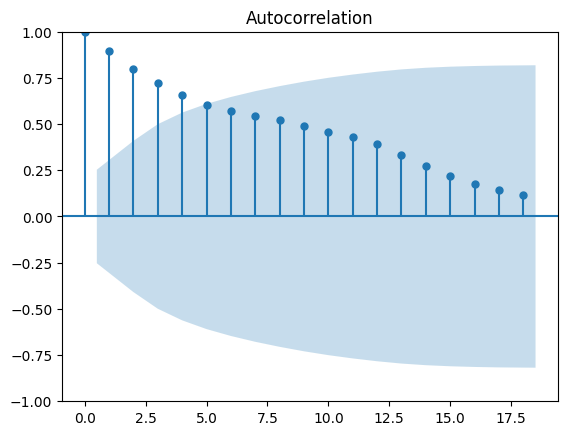

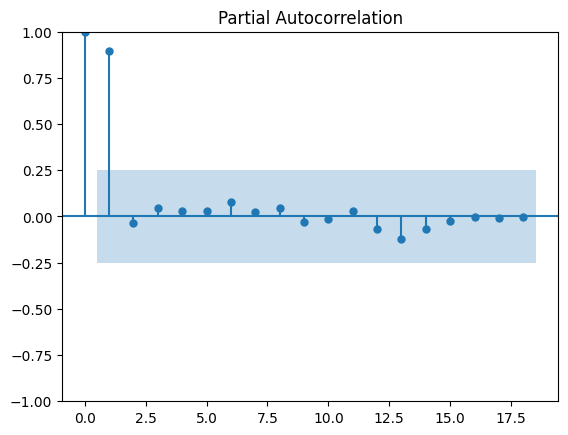

In [ ]:
y_train = train['Gold_Price']
y_test = test['Gold_Price']
exog_cols = ['Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']

exog_train = train[exog_cols]
exog_test = test[exog_cols]

plot_acf(y_train)
plot_pacf(y_train)
plt.show()

model = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False)
sarimax_result = model.fit(disp=False)
sarimax_forecast = sarimax_result.forecast(steps=len(y_test), exog=exog_test)

In [263]:
print(sarimax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Gold_Price   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -214.391
Date:                            Tue, 03 Jun 2025   AIC                            450.782
Time:                                    17:15:46   BIC                            467.244
Sample:                                         0   HQIC                           456.321
                                             - 60                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Crude_Oil         0.4293      0.271      1.583      0.113      -0.102       0.961
Interest_Rate  -253.3139  

MAPE для sarimax: 0.15946119402627912
MAPE для модели Хольта-Уинтерса: 0.39317307397183704


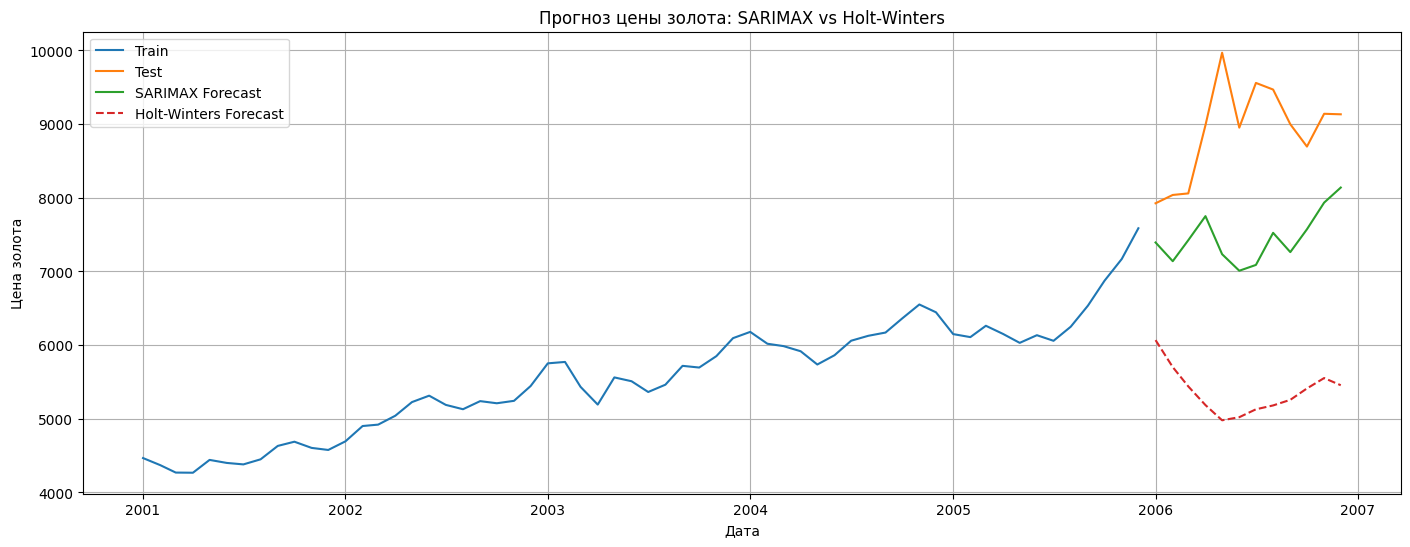

In [ ]:
sarimax_mape = mean_absolute_percentage_error(y_test, sarimax_forecast)
holt_test_mape = mean_absolute_percentage_error(y_test.values, pred[:12])
print(f'MAPE для sarimax: {sarimax_mape}')
print(f'MAPE для модели Хольта-Уинтерса: {holt_test_mape}')

plt.figure(figsize=(17,6))
plt.plot(train['Date'], y_train, label='Train')
plt.plot(test['Date'], y_test, label='Test')
plt.plot(test['Date'], sarimax_forecast, label='SARIMAX Forecast')

holt_forecast_dates = test['Date'].iloc[:len(pred)].values
plt.plot(holt_forecast_dates, pred[:len(pred)], label='Holt-Winters Forecast', linestyle='--')

plt.title('Прогноз цены золота: SARIMAX vs Holt-Winters')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Цена золота')
plt.grid(True)
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

y_train = train['Gold_Price']
y_test = test['Gold_Price']
exog_cols = ['Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']
exog_train = train[exog_cols]
exog_test = test[exog_cols]

best_mape = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

total_iterations = len(pdq) * len(seasonal_pdq)

In [ ]:
with tqdm(total=total_iterations) as pbar:
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(y_train,
                                order=param,
                                seasonal_order=seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                exog=exog_train)
                results = model.fit(disp=False)

                # Прогноз на тесте
                forecast = results.predict(
                    start=len(y_train),
                    end=len(y_train) + len(y_test) - 1,
                    exog=exog_test
                )

                # MAPE на тесте
                current_mape = mean_absolute_percentage_error(y_test, forecast)

                # Сохраняем, если лучше
                if current_mape < best_mape:
                    best_mape = current_mape
                    best_order = param
                    best_seasonal_order = seasonal_param
                    best_model = results

            except Exception:
                pass

            pbar.update(1)

print("Лучшая модель SARIMAX:")
print(f"order={best_order}, seasonal_order={best_seasonal_order}, MAPE={best_mape:.4f}")

100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

Лучшая модель SARIMAX:
order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), MAPE=0.0636
